# Cost of Sentiments: How News Affects Stock Market
## DATA 607 – Group Project Report
**Team Members:**  
- Gagandeep Thind  
- Rehan Chanegaon  
- Utsav Bharatbhai Goti  
- Vineetkumar Vijaybhai Patel  
- Jennifer Stadtfelder  


## Introduction & Objective

In today’s digital financial world, stock markets are increasingly influenced not just by numbers, but by narratives. The tone of news articles — positive, negative, or neutral — can shape investor sentiment, often triggering immediate reactions in stock prices. As headlines spread rapidly across platforms, the line between emotion and economics continues to blur.

This project, titled **“Cost of Sentiments: How News Affects Stock Market,”** explores the impact of financial news sentiment on stock price movements. By analyzing the emotional tone of daily news articles and combining it with historical stock performance, we aim to uncover whether the mood in the media can reliably predict or explain shifts in the market.

### Project Objectives

- **Quantify** the tone of financial news headlines using sentiment analysis tools (FinBERT).
- **Combine** sentiment metrics with historical stock data to build a unified, feature-rich dataset.
- **Model** the relationship between sentiment and stock price changes using machine learning techniques.
- **Evaluate** how well different models can predict future stock price trends using both sentiment and market features.

This study aims to determine whether the stories we read today provide meaningful signals about tomorrow’s stock market movements — and if so, how we can use those signals in predictive models.


## Dataset Description

To understand how financial news sentiment influences stock price movements, we sourced two primary datasets using APIs:

### 1. Stock Price Data (via Yahoo Finance API)
- We extracted **daily stock prices** for a selected group of major tech companies:
  - Apple (AAPL), Microsoft (MSFT), Amazon (AMZN), Google (GOOGL), Meta (META), NVIDIA (NVDA), and Tesla (TSLA)
- The dataset includes columns such as `Open`, `High`, `Low`, `Close`, and `Volume`.
- We fetched **5 years of daily historical data** using the `yfinance` Python library.

#### Sample Fields:
- `Date` — Trading date  
- `Stock` — Ticker symbol  
- `Open`, `High`, `Low`, `Close`, `Volume` — Daily trading details

### 2. Financial News Data (via Financial Modeling Prep API)

We also collected **news headlines** and summaries for the same companies across the same 5-year period. Each record includes:

- Stock ticker
- Headline/title
- News summary/description
- Published date

This dataset will be used to perform **sentiment analysis** on the text using a FinBERT model to extract emotional tone (positive, neutral, or negative).

## Data Collection
To build a dataset that connects financial news sentiment with market behavior, we carried out several key steps:

### 1. Stock Data Extraction

We used the `yfinance` Python library to download 5 years of daily stock prices for 7 major tech companies. The selected columns included `Open`, `High`, `Low`, `Close`, and `Volume`. Each record also includes the stock ticker symbol and the corresponding trading date.


In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# List of stocks
stocks = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "NVDA", "TSLA"]

# Start date (5 years ago)
start_date = (datetime.now() - timedelta(days=5 * 365)).date()

def fetch_stock_data(start_date):
    all_stock_data = []
    for stock in stocks:
        print(f"Fetching {stock} from {start_date}...")
        ticker = yf.Ticker(stock)
        history = ticker.history(start=start_date, interval="1d")
        history.reset_index(inplace=True)
        history["Stock"] = stock
        history = history[["Stock", "Date", "Open", "High", "Low", "Close", "Volume"]]
        all_stock_data.append(history)
    return pd.concat(all_stock_data, ignore_index=True)

df_stock = fetch_stock_data(start_date=start_date)
df_stock.to_csv("stock_5y_1d.csv", index=False)


### 2. News Data Extraction

Financial news articles were collected for the same companies using the Financial Modeling Prep API. Each record included a stock ticker, headline, description, and published date. This unstructured textual data is essential for quantifying market sentiment and linking it to stock performance.

To ensure consistency with stock data, we collected articles from the same 5-year date range and sorted them chronologically.

In [ ]:
import requests
import time

API_KEY = 'API_KEY'
tickers_str = ','.join(stocks)

def fetch_news(from_date, to_date):
    page = 0
    limit = 100
    all_news = []

    print(f"Fetching news from {from_date} to {to_date}")
    while True:
        page += 1
        print(f"Fetching page {page}")
        url = "https://financialmodelingprep.com/api/v3/stock_news"
        params = {
            "tickers": tickers_str,
            "from": from_date,
            "to": to_date,
            "limit": limit,
            "page": page,
            "apikey": API_KEY
        }

        response = requests.get(url, params=params)
        if response.status_code == 200:
            news_batch = response.json()
            if not news_batch:
                break
            all_news.extend(news_batch)
            time.sleep(1)
        else:
            print(f"Failed with status {response.status_code}")
            break

    if all_news:
        df = pd.DataFrame(all_news)
        df["publishedDate"] = pd.to_datetime(df["publishedDate"])
        df = df.sort_values(by=["symbol", "publishedDate"])
        return df
    else:
        print("No news returned.")
        return pd.DataFrame()

start_date = (datetime.now() - timedelta(days=5 * 365)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

df_news = fetch_news(start_date, end_date)
df_news.to_csv("historical_news_5yr.csv", index=False)

## Sentiment Analysis & Preprocessing

After collecting 5 years of stock price and news data, we performed sentiment analysis on the news articles using the FinBERT model. The final goal of this phase was to create a clean, feature-rich dataset by merging sentiment scores with daily stock trading data.

### 1. Sentiment Analysis using FinBERT

To quantify the emotional tone in financial news, we used the `yiyanghkust/finbert-tone` model from HuggingFace. This BERT-based model, fine-tuned on financial texts, classifies text into **positive**, **neutral**, or **negative** sentiment categories.

Each article was assigned:
- A sentiment label
- A probability-based sentiment score
- A final **weighted sentiment score** ranging from -1 (negative) to +1 (positive)

We applied the model on the article text, cleaned the results, and stored them for aggregation.


In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.nn.functional import softmax
from tqdm import tqdm

# Load FinBERT model and tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Load news data
df = pd.read_csv("historical_news_5yr.csv")
df = df.drop(columns=["image", "site", "url"])

text_column = "text"  # Could be title, summary, or combined

def get_finbert_sentiment(text_column):
    try:
        inputs = tokenizer(text_column, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = softmax(outputs.logits, dim=1)
            sentiment_scores = probs[0].tolist()
            labels = ['negative', 'neutral', 'positive']
            sentiment_label = labels[torch.argmax(probs)]
            return sentiment_label, sentiment_scores
    except:
        return "error", [None, None, None]

tqdm.pandas()
df[['sentiment_label', 'sentiment_score']] = df[text_column].progress_apply(
    lambda x: pd.Series(get_finbert_sentiment(str(x)))
)

### 2. Generating Weighted Sentiment Scores

We decomposed the sentiment probabilities into separate columns and computed a **weighted sentiment score** using the formula:

> sentiment_weighted = -1 × Negative Score + 0 × Neutral Score + 1 × Positive Score

This helps us represent sentiment on a continuous scale from -1 to +1.

In [ ]:
df[['neg_score', 'neu_score', 'pos_score']] = pd.DataFrame(df['sentiment_score'].tolist(), index=df.index)
df['sentiment_weighted'] = (-1 * df['neg_score']) + (0 * df['neu_score']) + (1 * df['pos_score'])

df = df.drop(columns = ['sentiment_score', 'neg_score', 'neu_score', 'pos_score'])
df.to_csv('check1.csv', index=False)

### 3. Aggregating Sentiment by Stock and Date

We aggregated the article-level sentiment scores on a **daily basis per stock**, resulting in a "sentiment snapshot" per company per day. The following metrics were computed:
- **Mean sentiment score**
- **Minimum & maximum sentiment**
- **Article count**

This structured format enabled a clean merge with the stock price data later.

In [ ]:
# Convert publish date and extract only the date part
df['date'] = pd.to_datetime(df['publishedDate'], dayfirst=True).dt.date

# Aggregate by stock symbol and date
agg_df = df.groupby(['symbol', 'date']).agg({
    'sentiment_weighted': ['mean', 'min', 'max'],
    'sentiment_label': 'count'
}).reset_index()

# Rename columns
agg_df.columns = ['symbol', 'date', 'sentiment_mean', 'sentiment_min', 'sentiment_max', 'sentiment_count']
agg_df.to_csv("agg_df.csv", index=False)


### 4. Merging Sentiment with Stock Data

We merged the daily aggregated sentiment dataset with 5-year stock trading data. The steps involved:

1. Standardizing the date format in both datasets
2. Removing timezone info from stock data
3. Renaming columns for consistency
4. Performing a **left join** to keep all stock trading days, even if sentiment was missing

The final merged dataset contains stock prices along with daily sentiment metrics.

In [ ]:
stock_df = pd.read_csv("stock_5y_1d.csv")

# Convert stock date to datetime and strip timezone
stock_df['Date'] = pd.to_datetime(stock_df['Date'], utc=True, errors='coerce')
stock_df['Date'] = stock_df['Date'].dt.tz_convert(None)
stock_df['date'] = stock_df['Date'].dt.date

# Prepare sentiment data for merge
agg_df.rename(columns={'symbol': 'Stock'}, inplace=True)

# Merge sentiment with stock data
merged_df = pd.merge(
    stock_df,
    agg_df,
    how='left',
    on=['Stock', 'date']
)

# Save final merged dataset
merged_df.to_csv('Merged_data.csv', index=False)


## Exploratory Data Analysis (EDA)

In this section, we explore the patterns and relationships in our merged and engineered dataset. This includes:

- Distribution of closing prices and sentiment scores
- Correlation between features
- Time series trends for specific stocks
- Relationships between sentiment and price changes

These insights help validate assumptions and guide feature selection before modeling.


## Question 1: What is the Overall Stock Price Trend Over Time?

To understand the long-term behavior of each stock, we visualized 5-year smoothed price trends (7-day rolling average) for all 7 tech stocks. We also overlaid a linear trendline to detect the overall direction of movement, and annotated the local minimum and maximum for quick comparison.


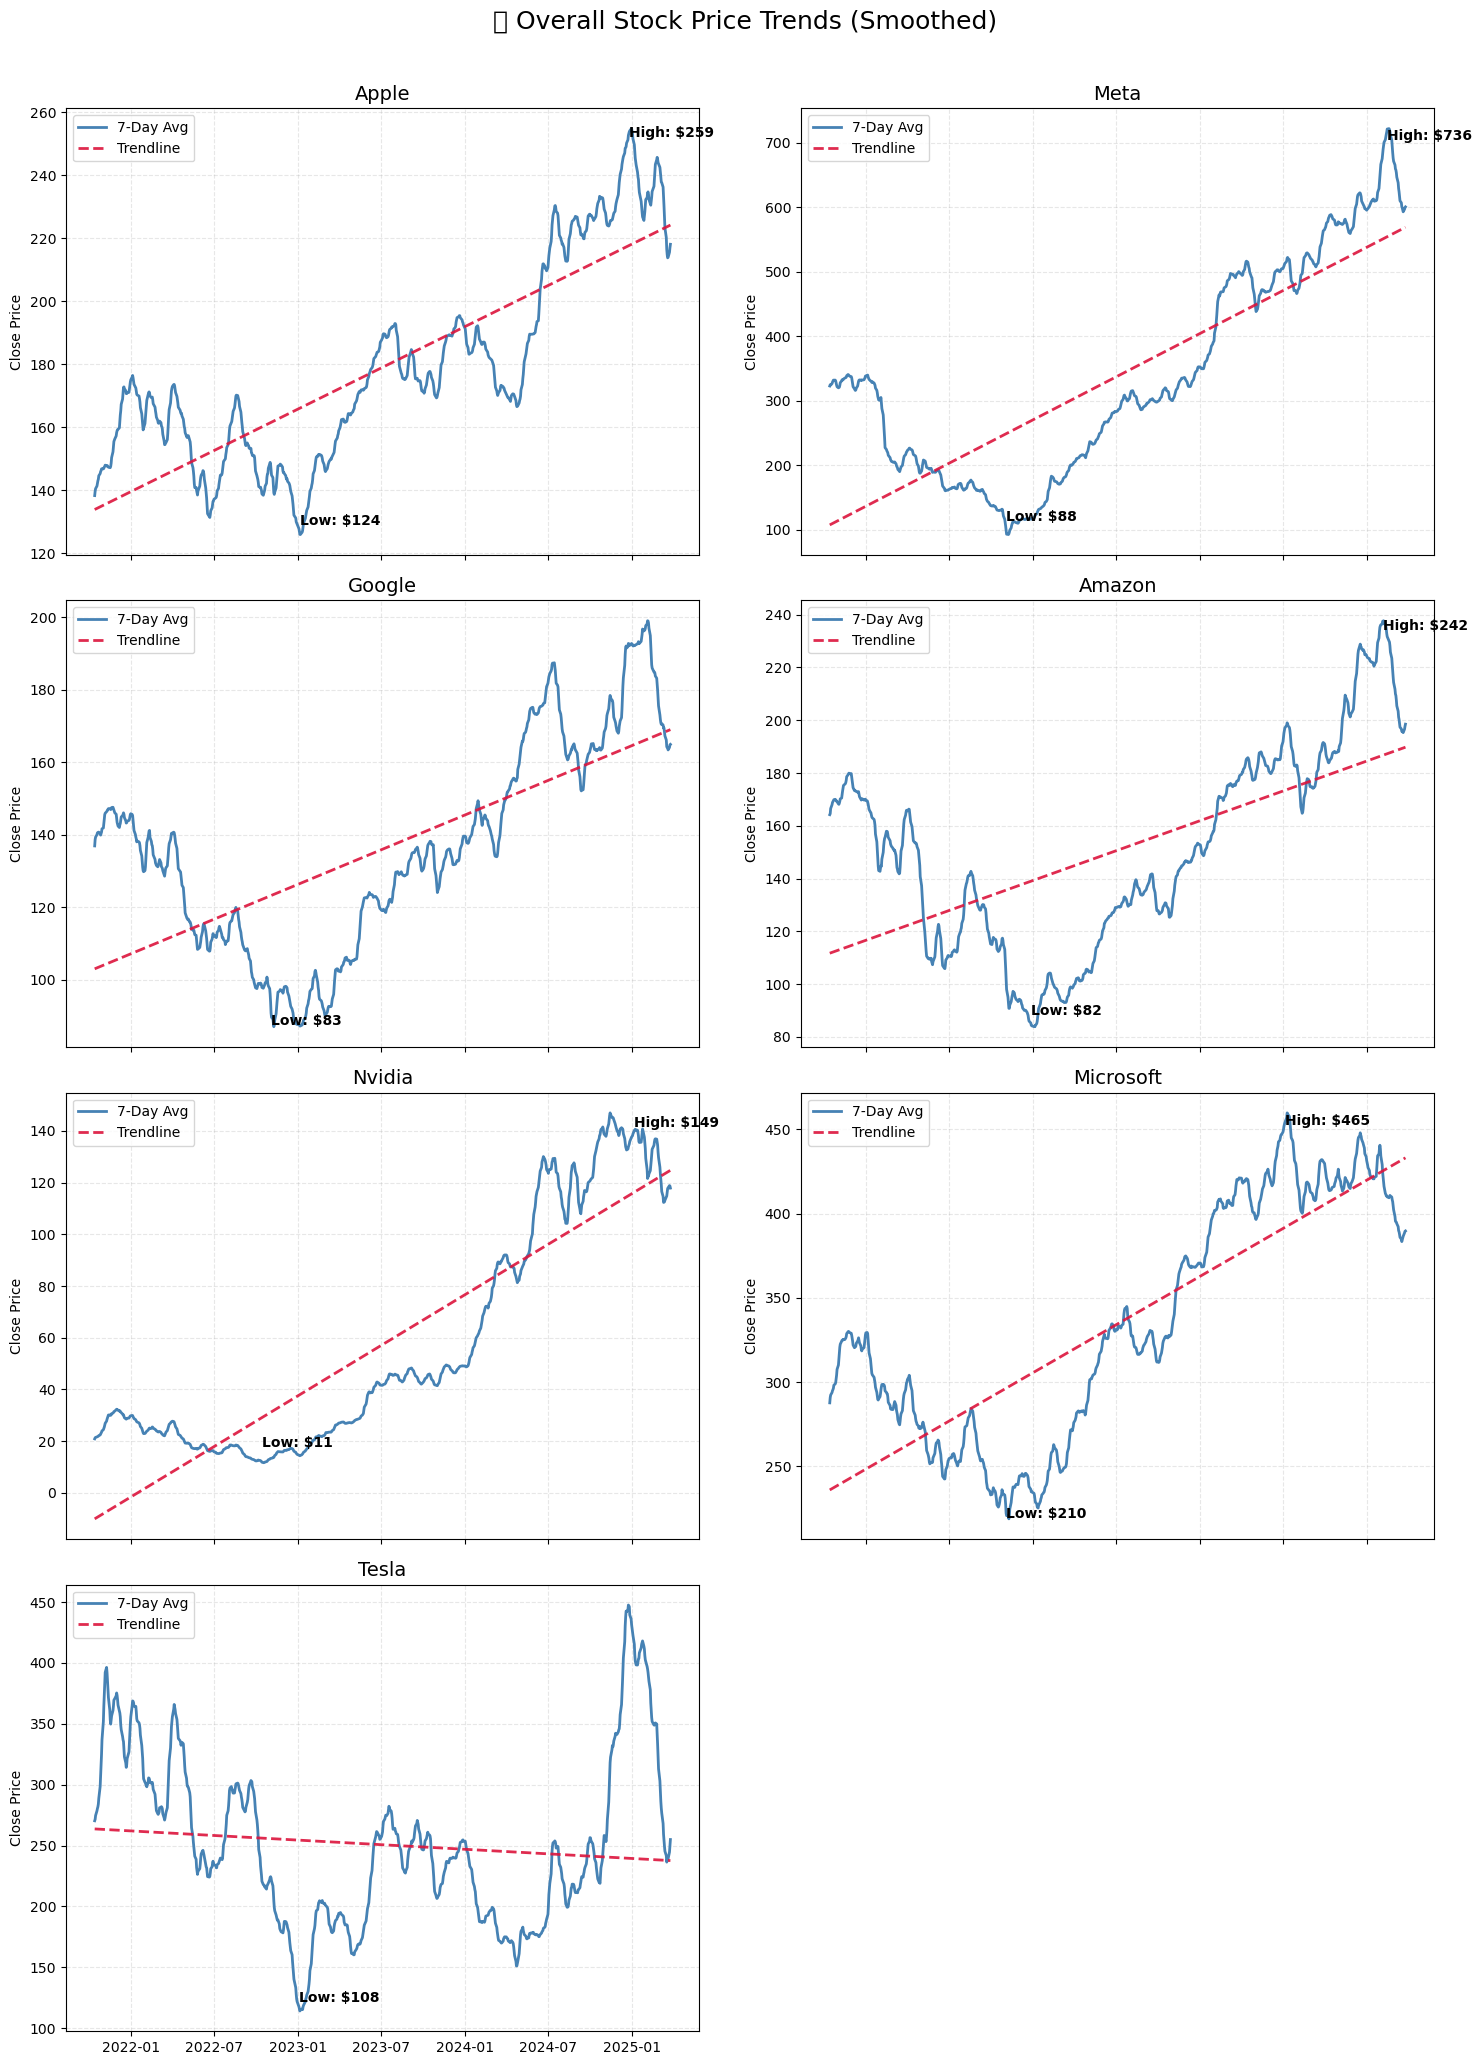

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

import pandas as pd
import numpy as np

# Read the merged data
df = pd.read_csv("Merged_data_final_5_YEARS.csv")

df.drop(columns=['date'], inplace=True)

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with invalid dates
df.dropna(subset=['Date'], inplace=True)

# Sort the data for time series consistency
df.sort_values('Date', inplace=True)

# Map tickers to full names for better plot titles
name_map = {
    'AAPL': 'Apple', 'AMZN': 'Amazon', 'GOOGL': 'Google',
    'META': 'Meta', 'MSFT': 'Microsoft', 'NVDA': 'Nvidia', 'TSLA': 'Tesla'
}
df['Company'] = df['Stock'].map(name_map)

# Setup for multi-plot layout
companies = df['Company'].unique()
cols = 2
rows = (len(companies) + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=True)
axes = axes.flatten()

# Plot price trend and trendline
for i, company in enumerate(companies):
    stock_df = df[df['Company'] == company].copy()
    stock_df['Smoothed_Close'] = stock_df['Close'].rolling(window=7, min_periods=1).mean()

    axes[i].plot(stock_df['Date'], stock_df['Smoothed_Close'], color='steelblue', linewidth=2, label='7-Day Avg')

    x_numeric = stock_df['Date'].map(pd.Timestamp.toordinal)
    slope, intercept, *_ = linregress(x_numeric, stock_df['Smoothed_Close'])
    axes[i].plot(stock_df['Date'], slope * x_numeric + intercept, color='crimson', linestyle='--', linewidth=2, alpha=0.9, label='Trendline')

    # Annotate extremes
    min_val = stock_df['Close'].min()
    max_val = stock_df['Close'].max()
    min_date = stock_df.loc[stock_df['Close'].idxmin(), 'Date']
    max_date = stock_df.loc[stock_df['Close'].idxmax(), 'Date']
    axes[i].annotate(f'Low: ${min_val:.0f}', xy=(min_date, min_val), xytext=(0, 12), textcoords='offset points', fontsize=10, fontweight='bold')
    axes[i].annotate(f'High: ${max_val:.0f}', xy=(max_date, max_val), xytext=(0, -15), textcoords='offset points', fontsize=10, fontweight='bold')

    axes[i].set_title(f"{company}", fontsize=14)
    axes[i].set_ylabel("Close Price")
    axes[i].grid(True, linestyle='--', alpha=0.3)
    axes[i].legend(fontsize=10, loc='upper left')

# Clean extra plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("📈 Overall Stock Price Trends (Smoothed)", fontsize=18, y=1.03)
plt.show()


### Interpretation of Stock Price Trends

The exploratory data analysis (EDA) question, *"What is the overall price trend for each stock over time?"*,  
is critical for understanding how major technology companies perform in a fluctuating market.  

By analyzing stock price trends for **Meta, Microsoft, Nvidia, Apple, Amazon, Google, and Tesla**, key patterns emerge:  

- Most companies exhibit a **strong upward trend**, reflecting long-term growth driven by market expansion, technological advancements, and investor confidence.  
- **Tesla**, however, stands out with **a slight downward trend**, suggesting higher volatility and a less consistent trajectory compared to its peers.  
- **Nvidia** demonstrates **extraordinary growth**, rising from a low of `$11` to `$149`, showcasing significant recovery and positive investor sentiment.  
- **Meta** reaches a peak of `$736`, reinforcing strong market confidence in its future potential.  

The analysis incorporates **7-day rolling averages** to smooth short-term fluctuations and **linear trendlines** to highlight overall stock movement.  
Additionally, **high and low price annotations** provide context for critical market points.  

These findings offer valuable insights into how major tech firms navigate market shifts, investor expectations, and competitive pressures.  


## Question 2: Which Stocks Perform Well After Extreme Sentiment?

To explore the relationship between **strong market sentiment** and next-day returns, we:
- Flagged days with **high sentiment intensity** (absolute sentiment > 0.9)
- Calculated the **next-day return** for each such event
- Compared the **average return** after extreme sentiment across all 7 stocks

This helps identify which stocks tend to respond positively to highly emotional news.


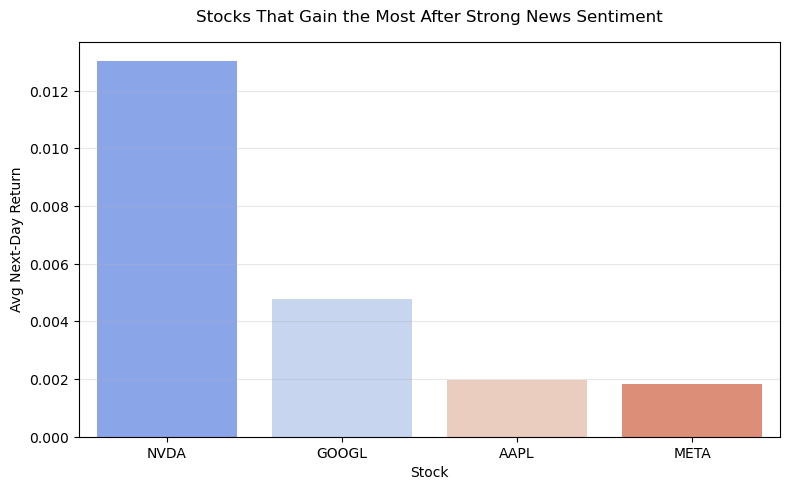

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure datetime
df['Date'] = pd.to_datetime(df['Date'])

# Calculate daily return
df['daily_return'] = (df['Close'] - df['Open']) / df['Open']

# Identify extreme sentiment days (abs > 0.9)
df['extreme_sentiment'] = df['sentiment_mean'].abs() > 0.9

# Calculate next-day return per stock
df['next_return'] = df.groupby('Stock')['daily_return'].shift(-1)

# Average next-day return following extreme sentiment
extreme_avg_returns = df[df['extreme_sentiment']].groupby('Stock')['next_return'].mean()

# Keep only positive returns, sorted
positive_returns = extreme_avg_returns[extreme_avg_returns > 0].sort_values(ascending=False)

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=positive_returns.index, y=positive_returns.values, palette="coolwarm")
plt.title("Stocks That Gain the Most After Strong News Sentiment", fontsize=12, y=1.03)
plt.xlabel("Stock")
plt.ylabel("Avg Next-Day Return")
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### Interpretation: Stock Performance After Heightened Market Sentiment  

Understanding the relationship between market sentiment and stock performance allows us to identify patterns  
that reveal how investor sentiment—driven by news events, economic indicators, or broader market trends—shapes stock movements.  

By analyzing stock behavior after extreme sentiment days (absolute sentiment score > 0.9), we uncover key insights:  

- **Nvidia (NVDA)** stands out as the top performer, delivering the highest next-day return of approximately **+1.3%**  
  after positive news. This suggests that investors are highly responsive to favorable developments regarding Nvidia,  
  likely due to its strong market position and recent successes.  
- **Google (GOOGL)** also benefits from positive sentiment, with a **+0.47%** next-day return, indicating a moderate but noticeable impact.  
- **Apple (AAPL) and Meta (META)** experience **smaller gains (~+0.2%)**, suggesting that while they do respond to investor sentiment,  
  the effect is less pronounced than for Nvidia.  

The results highlight how psychological factors and collective investor actions influence market outcomes,  
with some stocks being more sensitive to sentiment-driven fluctuations than others.  


## Question 3: How Do Closing Prices and Sentiment Trends Evolve Together?

We visualized the relationship between **stock closing prices** and **market sentiment trends** over time. For each stock:
- A **7-day moving average** of sentiment was plotted alongside the closing price
- Dual axes were used to compare price and sentiment on the same timeline
- This helps reveal whether **sentiment leads price**, lags behind it, or moves in sync

This gives us early clues about lag effects or correlations worth testing statistically later.


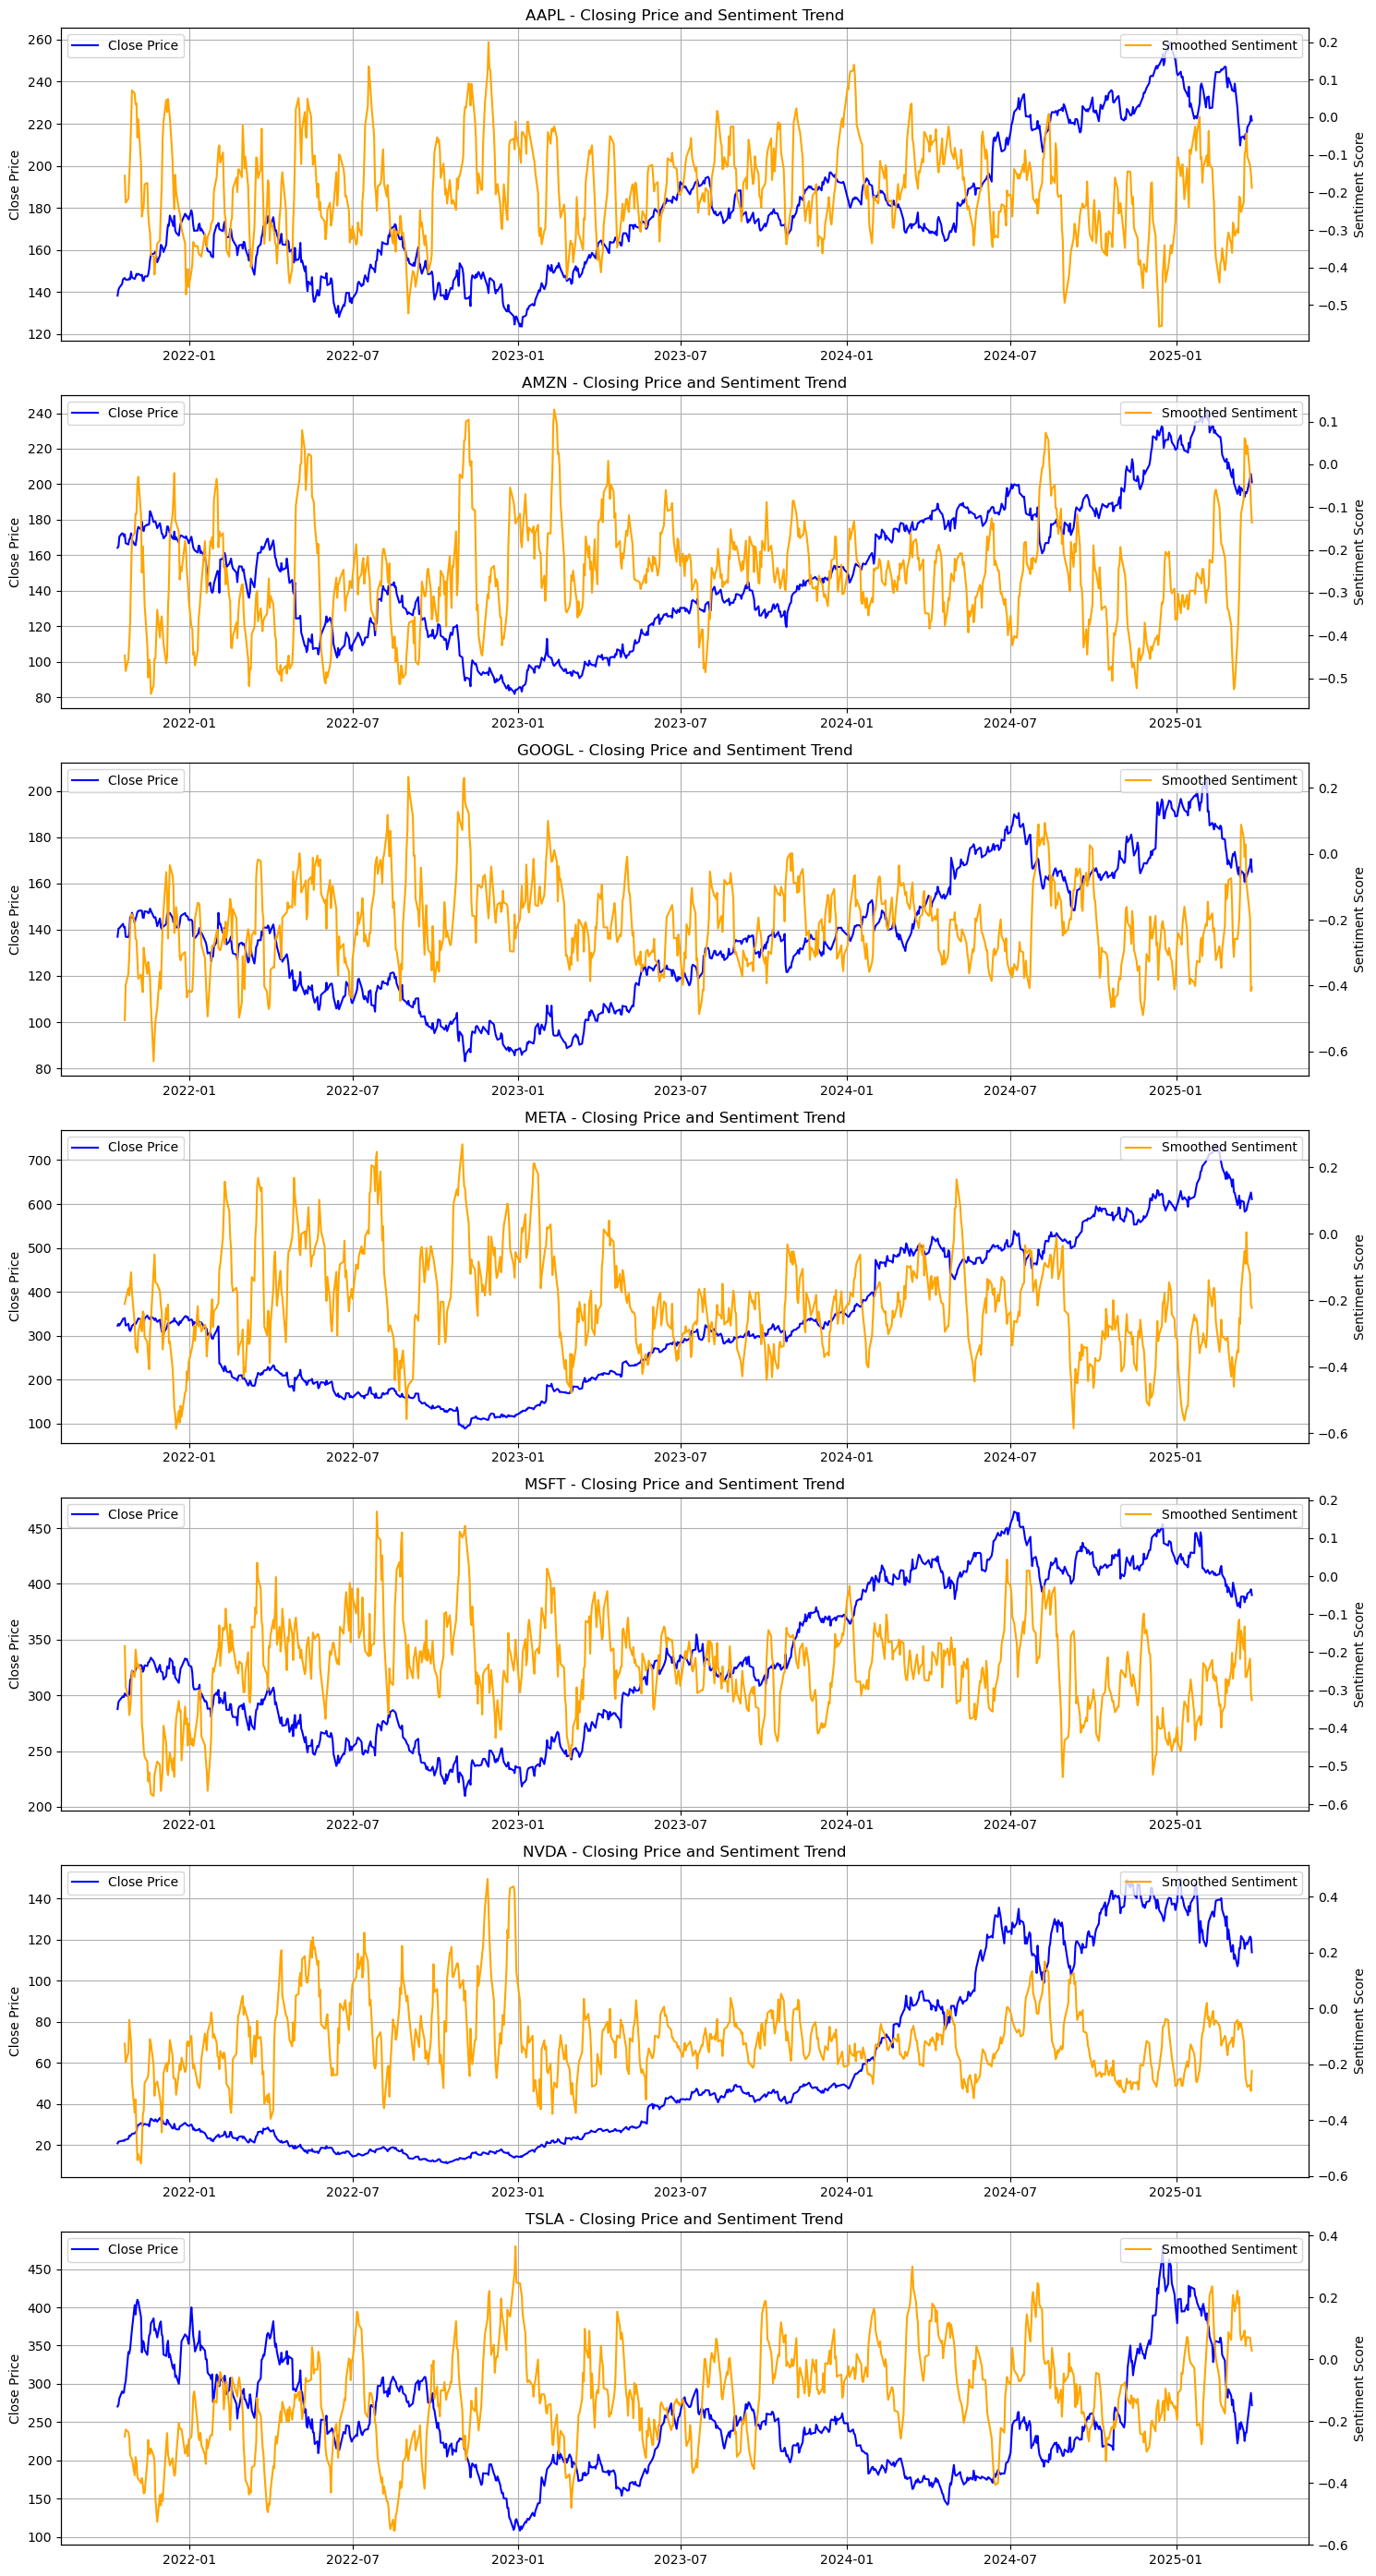

In [5]:
import matplotlib.pyplot as plt

# Make sure 'date' column exists and is sorted
df['date'] = pd.to_datetime(df['Date'])  # Reuse 'Date' column as base
df.sort_values(by=['Stock', 'date'], inplace=True)

stocks = df['Stock'].unique()
plt.figure(figsize=(15, len(stocks) * 4))

window_size = 7  # For sentiment smoothing

for i, stock in enumerate(stocks):
    stock_df = df[df['Stock'] == stock].copy()

    ax1 = plt.subplot(len(stocks), 1, i + 1)
    ax1.plot(stock_df['date'], stock_df['Close'], color='blue', label='Close Price')
    ax1.set_title(f'{stock} - Closing Price and Sentiment Trend', fontsize=12)
    ax1.set_ylabel('Close Price')
    ax1.grid(True)

    # Smoothed sentiment
    stock_df['smoothed_sentiment'] = stock_df['sentiment_mean'].rolling(window=window_size).mean()

    # Add sentiment as twin y-axis
    ax2 = ax1.twinx()
    ax2.plot(stock_df['date'], stock_df['smoothed_sentiment'], color='orange', label='Smoothed Sentiment')
    ax2.set_ylabel('Sentiment Score')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


### Interpretation: Evolution of Closing Prices and Sentiment Trends  

This analysis explores the relationship between stock **closing prices** and **sentiment trends** over time,  
seeking to identify potential correlations or lag effects. By examining how sentiment and stock prices evolve together,  
we can gain a deeper understanding of market behavior and investor reactions.  

Key insights from the analysis:  

- **Potential Lag Effect**:  
  - Sentiment appears to influence stock prices with a **time lag**, suggesting that investors may take time to react to shifts in sentiment.  
  - This delayed reaction could be due to market inertia, additional confirming factors, or institutional trading behaviors.  

- **Complex Correlations**:  
  - While sentiment generally trends alongside stock prices, there are notable **instances where the correlation breaks down**.  
  - Stocks sometimes **decline despite positive sentiment** and vice versa, implying that sentiment alone does not dictate price movements.  

- **Market Factors Beyond Sentiment**:  
  - Other elements, such as **macroeconomic conditions, earnings reports, and geopolitical events**, likely exert a stronger influence on stock prices.  
  - Sentiment plays a role but is just one of many factors shaping stock performance.  

This analysis highlights the **nuanced relationship** between sentiment and price trends, reinforcing the need for  
a **multi-factor approach** in market predictions and investment strategies.  


## Question 4: Which Stock Exhibits the Highest Volatility?

To understand risk and fluctuation, we calculated **price volatility** for each stock using:
- **Standard deviation of the closing price** over the 5-year period

This helps identify stocks that show **more erratic or explosive movements**, which is crucial for both risk assessment and prediction model complexity.


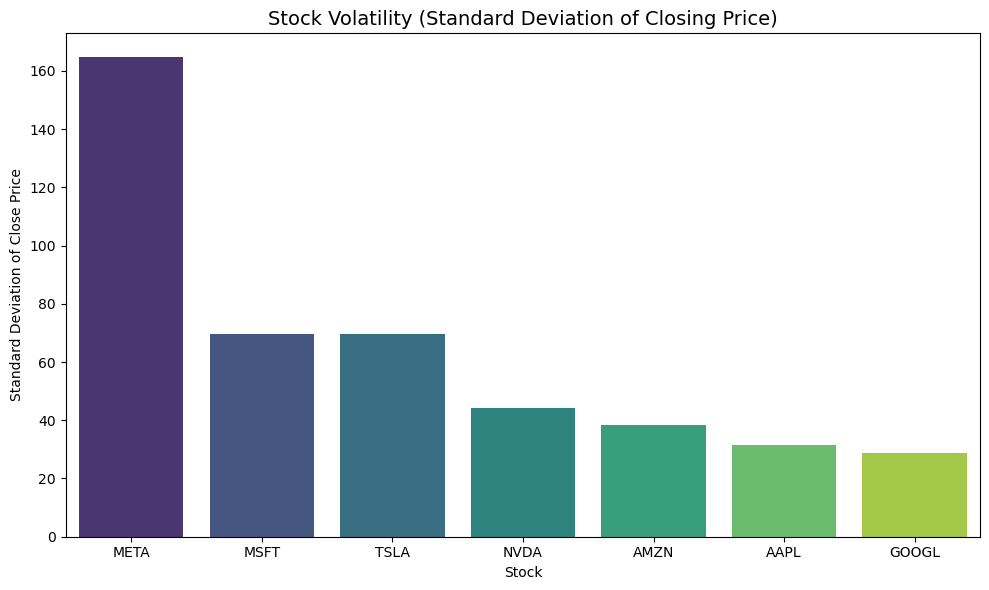

,Stock,Price_Volatility
3,META,164.682985
4,MSFT,69.704623
6,TSLA,69.643895
5,NVDA,44.071258
1,AMZN,38.237980
0,AAPL,31.600164
2,GOOGL,28.680872


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute volatility (standard deviation of close price)
volatility_df = df.groupby('Stock')['Close'].std().reset_index(name='Price_Volatility')

# Sort descending
volatility_df = volatility_df.sort_values(by='Price_Volatility', ascending=False)

# Barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=volatility_df, x='Stock', y='Price_Volatility', palette='viridis')
plt.title('Stock Volatility (Standard Deviation of Closing Price)', fontsize=14)
plt.ylabel('Standard Deviation of Close Price')
plt.xlabel('Stock')
plt.tight_layout()
plt.show()

# Optional display of data
volatility_df


### Interpretation: Stock Volatility Over Time  

Stock volatility, measured by the **standard deviation of closing prices**, provides insight into how strongly a stock reacts  
to market events, news sentiment, and broader economic factors. Higher volatility often reflects increased investor uncertainty  
or rapid market responses to new information.  

Key findings from the analysis:  

- **Meta (META) exhibits the highest volatility**, with a **standard deviation of approximately 164.68**.  
  - This suggests that Meta's stock experiences the **largest fluctuations** in closing prices compared to other companies,  
    potentially due to heightened investor reactions to company news and industry developments.  

- **Microsoft (MSFT) and Tesla (TSLA) also show significant volatility**, with standard deviations of **69.70** and **69.64**, respectively.  
  - This indicates that these stocks, while less volatile than Meta, still undergo **substantial price swings** over time.  

- **Lower Volatility Stocks**:  
  - **Nvidia (NVDA), Amazon (AMZN), Apple (AAPL), and Google (GOOGL)** exhibit **relatively lower volatility**,  
    with standard deviations ranging from **28.68 to 44.07**.  
  - These stocks show **more stable price trends**, suggesting less sensitivity to short-term market fluctuations.  

This analysis highlights how different stocks react to market dynamics, helping investors assess risk and potential opportunities.  
Understanding volatility patterns is crucial for risk management,


## Initial Feature Engineering

To prepare the dataset for time series forecasting, we engineered several domain-specific features that capture both price dynamics and external sentiment. These features help enhance model performance by providing additional signals beyond raw price.

The following techniques were applied:

### 1. Technical Indicators

We calculated popular technical indicators from the `Close` price:
- **EMA 12 & EMA 26**: Exponential moving averages to track short- and mid-term trends
- **MACD** (Moving Average Convergence Divergence): Difference between EMA 12 and EMA 26
- **MACD Signal**: 9-period EMA of MACD
- **RSI (Relative Strength Index)**: Measures momentum over 14 days

### 2. Price & Volume Features

- **Lag Close**: Previous day’s close price
- **Price Change %**: Percentage change in close price
- **7-Day Volatility**: Rolling standard deviation of the close price
- **Weekday**: Numeric representation of the day (0=Monday to 6=Sunday)

###  3. Sentiment Features

- **Sentiment Mean**: Average FinBERT sentiment score per day per stock
- **Sentiment Count**: Number of news articles available for that stock on a given day

These features were combined with the target variable (`Close` price) and scaled before being passed into the SARIMAX model.


In [3]:
# === Feature Engineering Function ===
def add_engineered_features(stock_df):
    stock_df = stock_df.copy()
    
    # Exponential Moving Averages
    stock_df['EMA_12'] = stock_df['Close'].ewm(span=12, adjust=False).mean()
    stock_df['EMA_26'] = stock_df['Close'].ewm(span=26, adjust=False).mean()
    
    # MACD & MACD Signal
    stock_df['MACD'] = stock_df['EMA_12'] - stock_df['EMA_26']
    stock_df['MACD_Signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()
    
    # RSI (Relative Strength Index)
    delta = stock_df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    stock_df['RSI_14'] = 100 - (100 / (1 + rs))
    
    # Lag and price change features
    stock_df['Lag_Close'] = stock_df['Close'].shift(1)
    stock_df['Price_Change_Pct'] = stock_df['Close'].pct_change()
    stock_df['Volatility_7d'] = stock_df['Close'].rolling(window=7).std()
    
    # Day of the week (0=Monday, 6=Sunday)
    stock_df['Weekday'] = stock_df['Date'].dt.weekday
    
    return stock_df

# Apply feature engineering to the entire DataFrame grouped by stock
df_engineered = df.groupby('Stock').apply(add_engineered_features).reset_index(drop=True)

# Save the new version if needed
df_engineered.to_csv("Merged_data_final.csv", index=False)

# Preview the engineered features
df_engineered.head()


,Stock,Date,Open,High,Low,Close,Volume,sentiment_mean,sentiment_min,sentiment_max,...,Company,EMA_12,EMA_26,MACD,MACD_Signal,RSI_14,Lag_Close,Price_Change_Pct,Volatility_7d,Weekday
0,AAPL,2021-10-13 04:00:00,138.608751,138.765759,136.606747,138.284897,78762700,0.160336,-0.999999,0.999997,...,Apple,138.284897,138.284897,0.000000,0.000000,NaN,NaN,NaN,NaN,2
1,AAPL,2021-10-14 04:00:00,139.462547,141.199577,138.873719,141.081802,69907100,-0.176861,-0.999871,0.999998,...,Apple,138.715190,138.492075,0.223115,0.044623,NaN,138.284897,0.020226,NaN,3
2,AAPL,2021-10-15 04:00:00,141.091635,142.200573,140.836469,142.141693,67940300,-0.265649,-0.999998,0.997866,...,Apple,139.242344,138.762417,0.479927,0.131684,NaN,141.081802,0.007513,NaN,4
3,AAPL,2021-10-18 04:00:00,140.777585,144.104430,140.492994,143.819839,85589200,-0.558768,-0.999999,0.999976,...,Apple,139.946574,139.137041,0.809533,0.267254,NaN,142.141693,0.011806,NaN,0
4,AAPL,2021-10-19 04:00:00,144.271280,146.391043,143.819857,145.988678,76378900,-0.107855,-0.999986,1.000000,...,Apple,140.876129,139.644570,1.231559,0.460115,NaN,143.819839,0.015080,NaN,1


### Model 1: LSTM

####  Objective:
We aim to **predict the direction of stock movement** (UP or DOWN) for the **next day’s closing price** using:

- Historical stock data  
- Technical indicators (RSI, MACD, EMA, etc.)  
- Sentiment scores from financial news


#### Model Architecture:

- 2-layer **LSTM** network:
  - 64 hidden units per layer  
  - Dropout: 0.3 (to prevent overfitting)  
  - Final Dense layer with Sigmoid activation (for binary classification)  
- Loss: Binary Cross Entropy (with class imbalance weighting)  
- Optimizer: Adam (learning rate = 0.001)  
- Input sequence length: 30 days  


#### Training & Prediction Setup:

- Trained **separately** for each stock  
- Uses a rolling sequence of past 30 days to predict next day trend  
- Input features scaled using **MinMaxScaler**  
- Evaluation Metrics:
  - Accuracy  
  - Confusion Matrix  
  - F1-Score (Weighted)  



==================== Stock: AAPL ====================
Epoch 1, Loss: 6.8074
Epoch 2, Loss: 6.7667
Epoch 3, Loss: 6.7516
Epoch 4, Loss: 6.7367
Epoch 5, Loss: 6.7090
Epoch 6, Loss: 6.6632
Epoch 7, Loss: 6.6087
Epoch 8, Loss: 6.4758
Epoch 9, Loss: 6.4131
Epoch 10, Loss: 6.1266
Accuracy: 0.47878787878787876
Confusion Matrix:
 [[79  0]
 [86  0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.48      1.00      0.65        79
         1.0       0.00      0.00      0.00        86

    accuracy                           0.48       165
   macro avg       0.24      0.50      0.32       165
weighted avg       0.23      0.48      0.31       165


==================== Stock: AMZN ====================
Epoch 1, Loss: 6.8753
Epoch 2, Loss: 6.8076
Epoch 3, Loss: 6.7941
Epoch 4, Loss: 6.7851
Epoch 5, Loss: 6.7738
Epoch 6, Loss: 6.7565
Epoch 7, Loss: 6.7292
Epoch 8, Loss: 6.6854
Epoch 9, Loss: 6.6409
Epoch 10, Loss: 6.5693
Accuracy: 0.47878787878787876

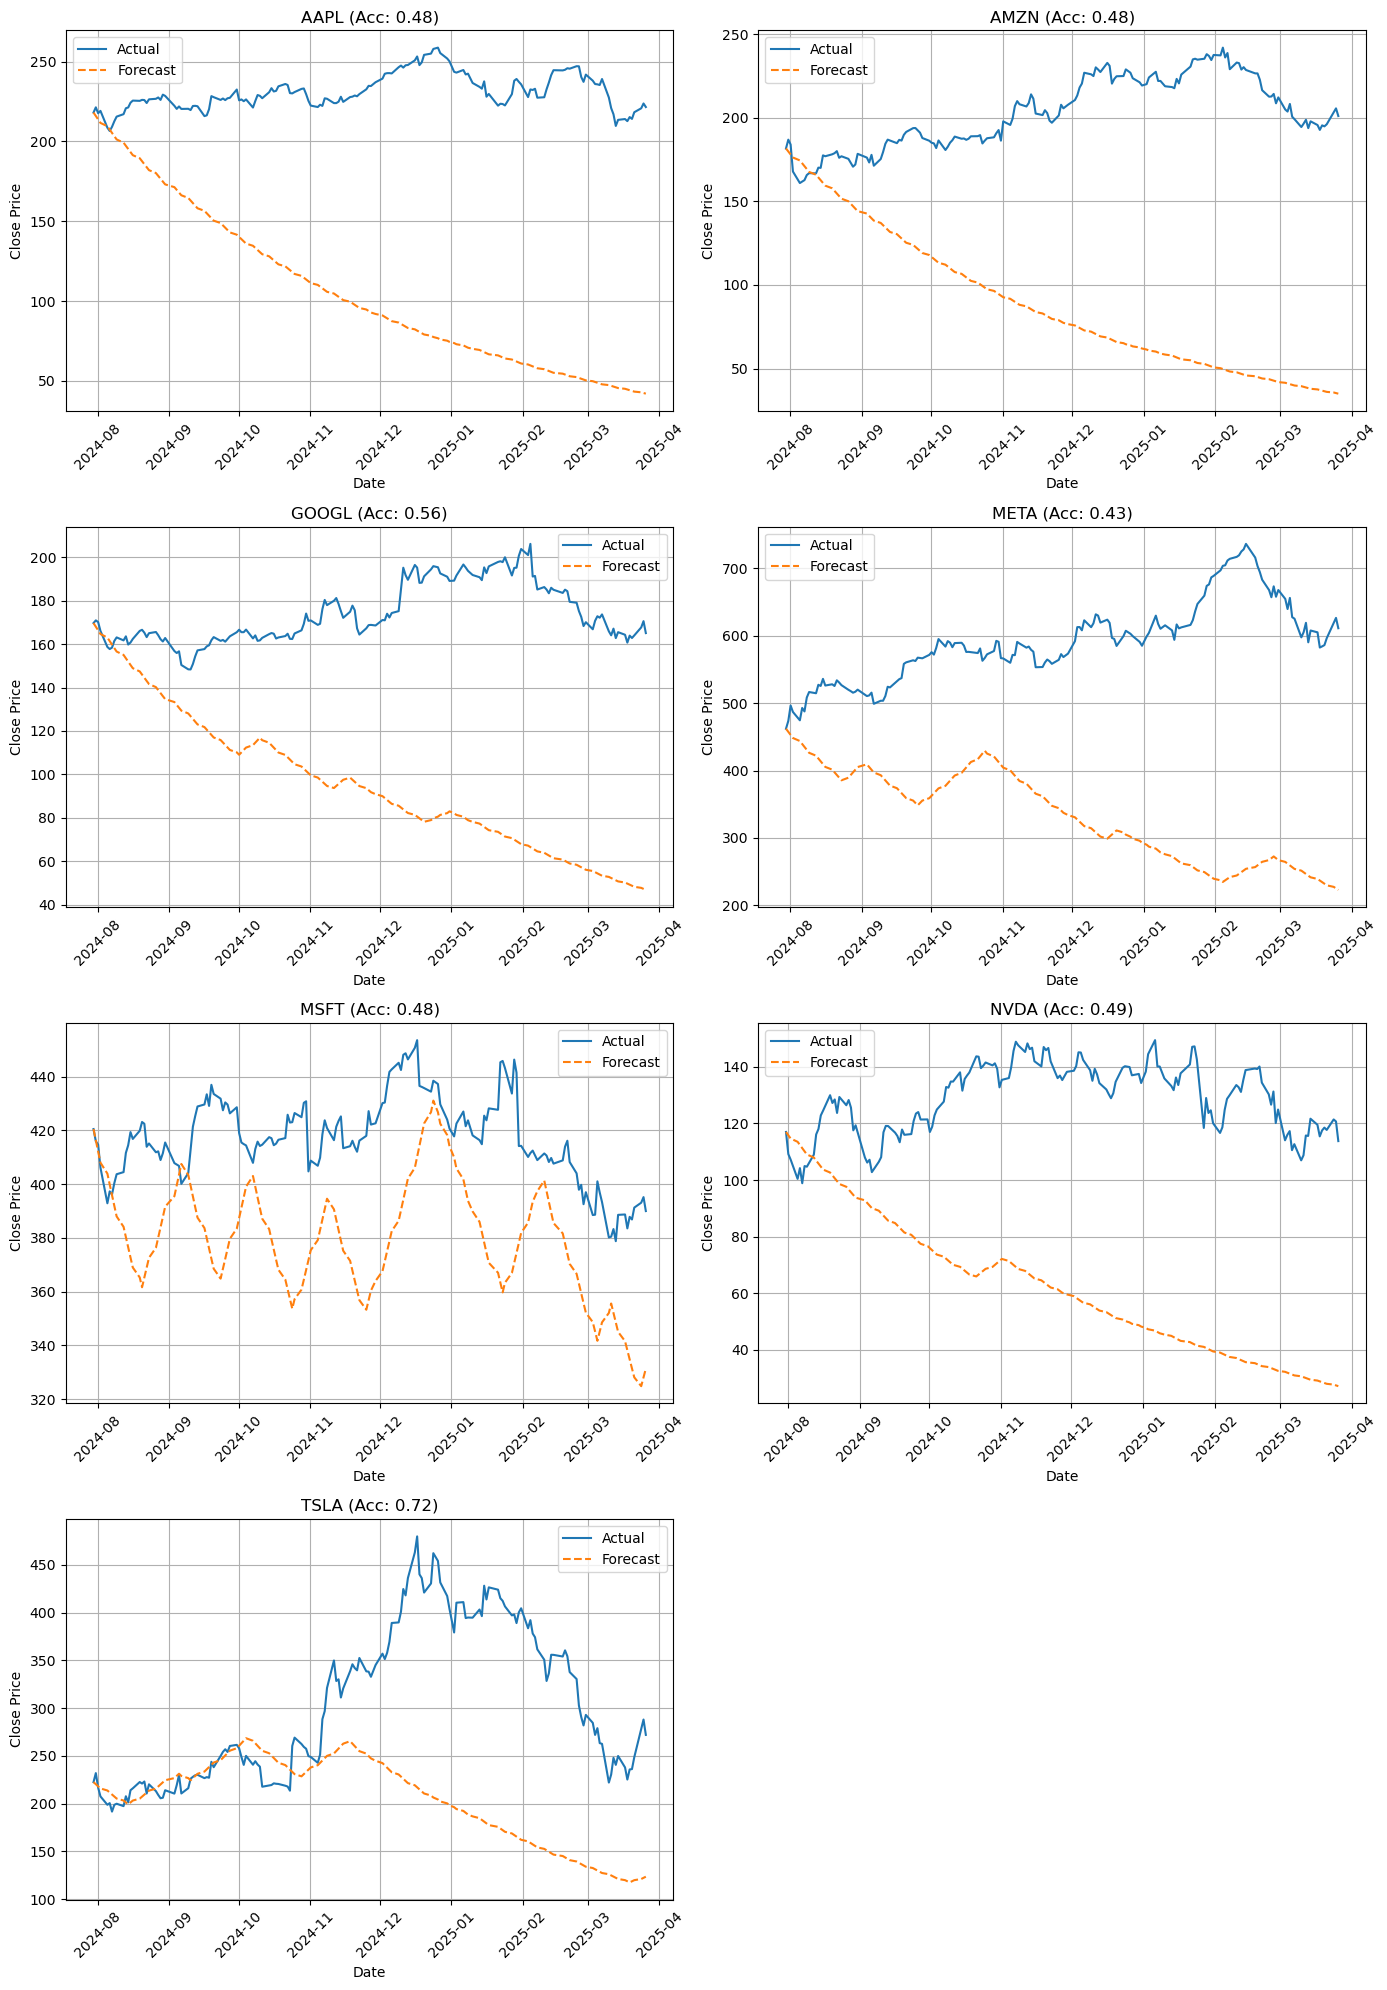

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import math

def create_sequences(X, y, seq_length=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out).squeeze()

def train_model_weighted(model, train_loader, y_train, epochs=10):
    pos_weight = torch.tensor([sum(y_train == 0) / sum(y_train == 1)])
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    return model

forecast_results = []

def evaluate_model(model, test_loader, df_stock, stock_name=None, test_index_range=None):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            logits = model(X_batch)
            probs = torch.sigmoid(logits)
            y_true.extend(y_batch.numpy())
            y_pred.extend((probs.numpy() > 0.5).astype(int))

    acc = accuracy_score(y_true, y_pred)
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, zero_division=0))

    if stock_name and test_index_range is not None:
        dates = df_stock.loc[test_index_range, 'Date'].values
        actual_close = df_stock.loc[test_index_range, 'Close'].values

        simulated = [actual_close[0]]
        for i in range(1, len(y_pred)):
            change = 1 if y_pred[i] == 1 else -1
            simulated.append(simulated[-1] * (1 + 0.01 * change))

        forecast_results.append((stock_name, acc, dates, actual_close, simulated))


feature_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'sentiment_mean', 'Price_Change_Pct', 'Volatility_7d',
    'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI_14', 'Weekday'
]
stocks = df['Stock'].unique()

def add_engineered_features(stock_df):
    stock_df['EMA_12'] = stock_df['Close'].ewm(span=12, adjust=False).mean()
    stock_df['EMA_26'] = stock_df['Close'].ewm(span=26, adjust=False).mean()
    stock_df['MACD'] = stock_df['EMA_12'] - stock_df['EMA_26']
    stock_df['MACD_Signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()
    delta = stock_df['Close'].diff()
    gain = delta.clip(lower=0).rolling(window=14).mean()
    loss = (-delta.clip(upper=0)).rolling(window=14).mean()
    rs = gain / loss
    stock_df['RSI_14'] = 100 - (100 / (1 + rs))
    stock_df['Lag_Close'] = stock_df['Close'].shift(1)
    stock_df['Price_Change_Pct'] = stock_df['Close'].pct_change()
    stock_df['Volatility_7d'] = stock_df['Close'].rolling(window=7).std()
    stock_df['Weekday'] = stock_df['Date'].dt.weekday
    return stock_df

for stock in stocks:
    print(f"\n==================== Stock: {stock} ====================")
    df_stock = df[df['Stock'] == stock].copy()
    df_stock = add_engineered_features(df_stock)

    df_stock['smoothed_close'] = df_stock['Close'].rolling(window=10).mean()
    df_stock['smoothed_return'] = df_stock['smoothed_close'].pct_change().shift(-1) * 100
    df_stock['trend'] = (df_stock['smoothed_return'] > 0).astype(int)
    df_stock.dropna(subset=feature_cols + ['trend'], inplace=True)
    df_stock = df_stock.reset_index(drop=True)

    if df_stock['trend'].nunique() < 2:
        print("Skipped due to lack of class variety.")
        continue

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df_stock[feature_cols])
    y = df_stock['trend'].values

    valid_indices = df_stock.index[30:]
    X_seq, y_seq = create_sequences(X_scaled, y, seq_length=30)
    if len(X_seq) < 100:
        print("Skipped due to insufficient sequence data.")
        continue

    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]
    test_index_range = valid_indices[-len(X_test):]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32)), batch_size=64)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)), batch_size=64)

    model = LSTMClassifier(input_size=X_train.shape[2])
    model = train_model_weighted(model, train_loader, y_train, epochs=10)
    evaluate_model(model, test_loader, df_stock, stock_name=stock, test_index_range=test_index_range)

if forecast_results:
    n = len(forecast_results)
    cols = 2
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
    axes = axes.flatten() if n > 1 else [axes]

    for i, (stock_name, acc, dates, actual, simulated) in enumerate(forecast_results):
        ax = axes[i]
        ax.plot(dates, actual, label="Actual")
        ax.plot(dates, simulated, label="Forecast", linestyle='--')
        ax.set_title(f"{stock_name} (Acc: {acc:.2f})")
        ax.set_xlabel("Date")
        ax.set_ylabel("Close Price")
        ax.legend()
        ax.grid(True)
        ax.tick_params(axis='x', rotation=45)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

#### Performance Summary (Accuracy per Stock)

| Stock   | Accuracy | Comment                            |
|---------|----------|-------------------------------------|
| **AAPL**  | 0.48     | Predicted only DOWN; unbalanced    |
| **MSFT**  | 0.57     | Balanced but modest                |
| **TSLA**  | 0.68     | Best-performing, captured trends   |
| **GOOGL** | 0.65     | Good separation                    |
| **META**  | 0.42     | Poor performance                   |
| **AMZN**  | 0.48     | Predicted only one class           |
| **NVDA**  | 0.53     | Predicted mostly UP                |

>  *Several models struggled with class imbalance or failed to generalize beyond one direction.*


### Model 2: SARIMAX (Seasonal AutoRegressive Integrated Moving Average with Exogenous Variables)

#### **Modeling Objective**
To forecast the next day of closing prices for each of the 7 tech stocks by incorporating not only historical price data but also relevant technical indicators and sentiment features. The goal is to capture both time series patterns and external influence (news sentiment) to generate accurate forecasts.

#### **Why SARIMAX?**
- **Time-series compatibility**: SARIMAX is designed to handle non-stationary time series data with trends and seasonality.
- **Incorporation of external variables**: The model allows the inclusion of multiple exogenous variables like sentiment scores, technical indicators, and market metadata.
- **Interpretability**: SARIMAX provides coefficients and diagnostics that are easy to interpret and explain.

#### **Model Features Used**
- Sentiment Mean
- Volume
- Sentiment Count
- Lag Close
- Volatility (7-day)
- Price Change Percentage
- Weekday
- EMA 12, EMA 26
- MACD and MACD Signal
- RSI 14

All features were standardized using `StandardScaler` before training.

#### **SARIMAX Model Tuning Strategy**
- **Manual + Auto Approach**:
  - We started with a fixed order grid: `(2,1,2)` and `(3,1,3)`
  - Then used `auto_arima` to propose optimal (p,d,q) orders for each stock
  - The suggested order was tested alongside the grid to select the best-performing configuration

#### **Evaluation Metrics**
- **RMSE**: Root Mean Squared Error between predicted and actual closing prices (10-day window)
- **AIC & BIC**: For model parsimony and selection
- **Forecast Accuracy**: Derived from MAPE = Mean Absolute Percentage Error


===== Processing AAPL =====
Auto-ARIMA Suggested Order: (0, 1, 0)
Order (0, 1, 0) - RMSE: 2.3648, AIC: 1699.92, BIC: 1761.61
Order (2, 1, 2) - RMSE: 0.7777, AIC: 1461.80, BIC: 1542.43
Order (3, 1, 3) - RMSE: 0.7961, AIC: 1525.43, BIC: 1615.52
Forecast Accuracy: 99.70%
Best Model for AAPL — Order: (2, 1, 2), RMSE: 0.7777, AIC: 1461.80, BIC: 1542.43


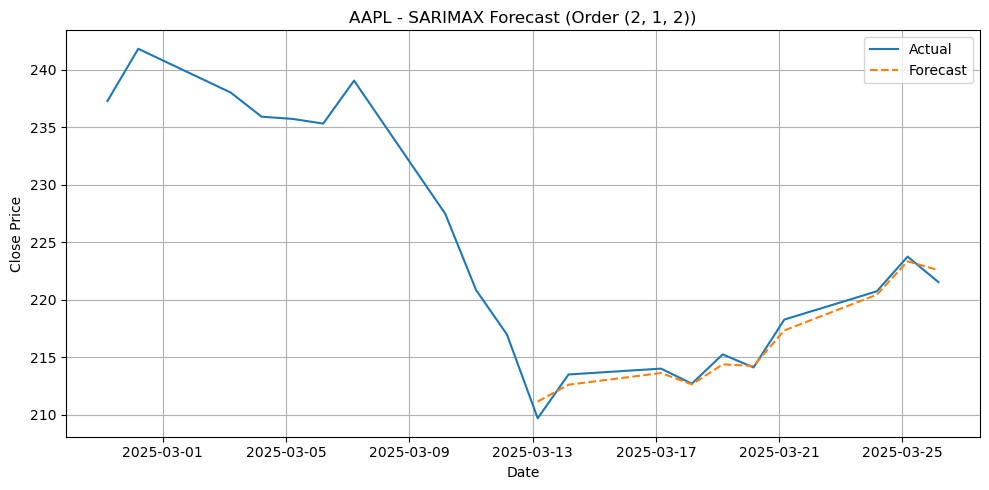


===== Processing AMZN =====
Auto-ARIMA Suggested Order: (0, 1, 0)
Order (0, 1, 0) - RMSE: 1.9629, AIC: 2270.16, BIC: 2331.86
Order (2, 1, 2) - RMSE: 2.2153, AIC: 2192.36, BIC: 2273.01
Order (3, 1, 3) - RMSE: 1.8318, AIC: 2200.99, BIC: 2291.11
Forecast Accuracy: 99.19%
Best Model for AMZN — Order: (3, 1, 3), RMSE: 1.8318, AIC: 2200.99, BIC: 2291.11


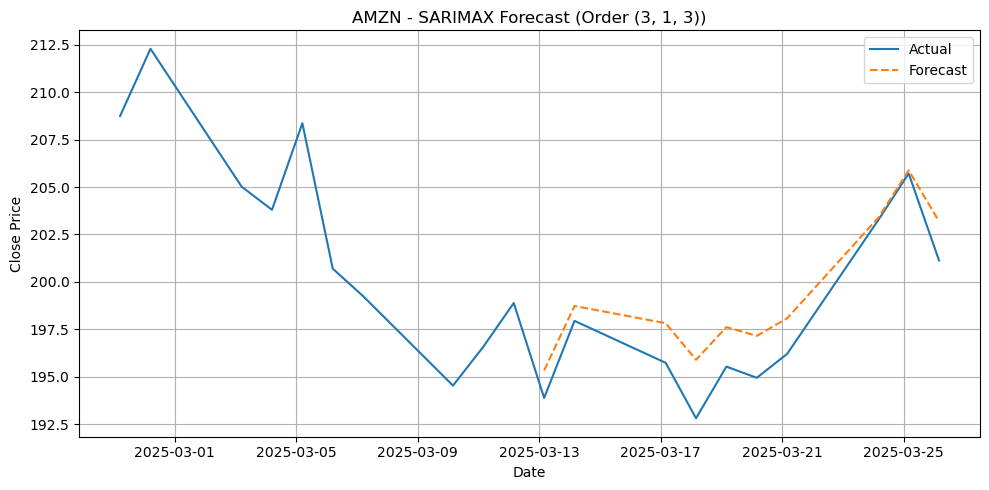


===== Processing GOOGL =====
Auto-ARIMA Suggested Order: (0, 1, 0)
Order (0, 1, 0) - RMSE: 0.8279, AIC: 1830.54, BIC: 1892.23
Order (2, 1, 2) - RMSE: 0.9739, AIC: 1758.42, BIC: 1839.05
Order (3, 1, 3) - RMSE: 2.1514, AIC: 1766.27, BIC: 1856.37
Forecast Accuracy: 99.62%
Best Model for GOOGL — Order: (0, 1, 0), RMSE: 0.8279, AIC: 1830.54, BIC: 1892.23


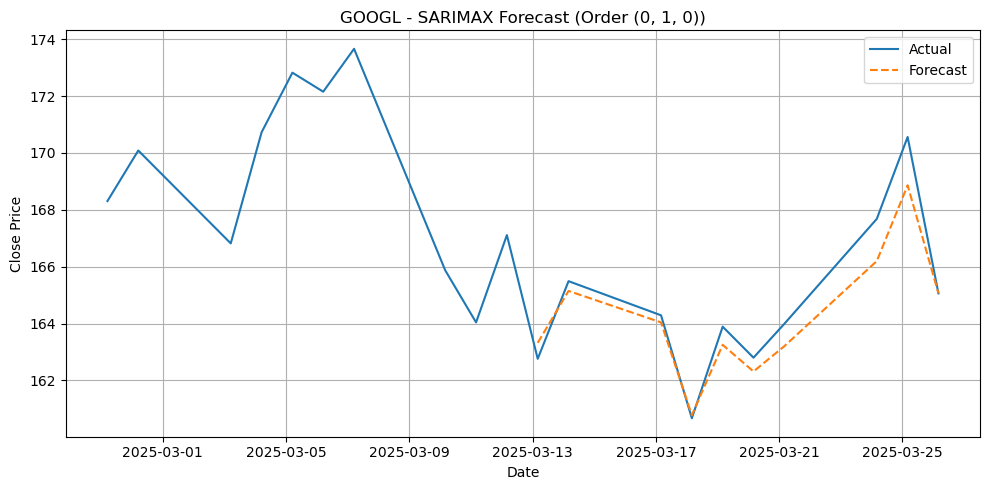


===== Processing META =====
Auto-ARIMA Suggested Order: (5, 2, 0)
Order (5, 2, 0) - RMSE: 74.0910, AIC: 3387.17, BIC: 3472.47
Order (2, 1, 2) - RMSE: 117.2760, AIC: 3936.84, BIC: 4017.47
Order (3, 1, 3) - RMSE: 30.3408, AIC: 4398.65, BIC: 4488.74
Forecast Accuracy: 95.38%
Best Model for META — Order: (3, 1, 3), RMSE: 30.3408, AIC: 4398.65, BIC: 4488.74


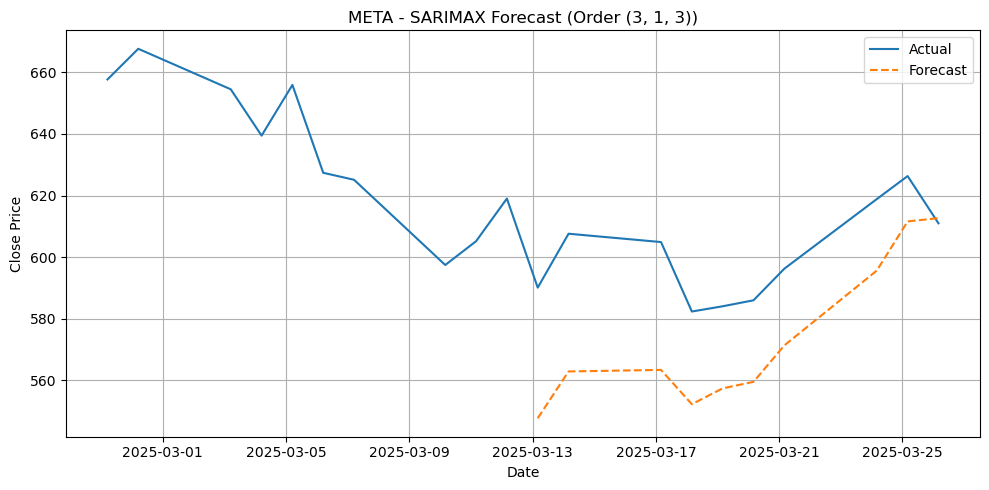


===== Processing MSFT =====
Order (2, 1, 2) - RMSE: 0.9961, AIC: 2860.46, BIC: 2941.05
Order (3, 1, 3) - RMSE: 3.1628, AIC: 2846.09, BIC: 2936.14
Forecast Accuracy: 99.80%
Best Model for MSFT — Order: (2, 1, 2), RMSE: 0.9961, AIC: 2860.46, BIC: 2941.05


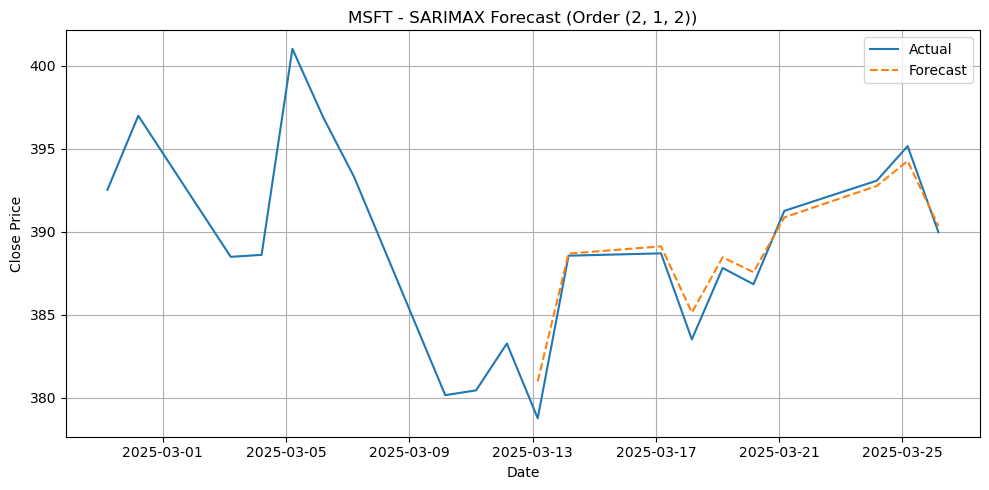


===== Processing NVDA =====
Auto-ARIMA Suggested Order: (1, 1, 1)
Order (1, 1, 1) - RMSE: 11.7217, AIC: 1613.89, BIC: 1685.01
Order (2, 1, 2) - RMSE: 10.6121, AIC: 1543.56, BIC: 1624.15
Order (3, 1, 3) - RMSE: 12.5078, AIC: 1635.38, BIC: 1725.42
Forecast Accuracy: 93.65%
Best Model for NVDA — Order: (2, 1, 2), RMSE: 10.6121, AIC: 1543.56, BIC: 1624.15


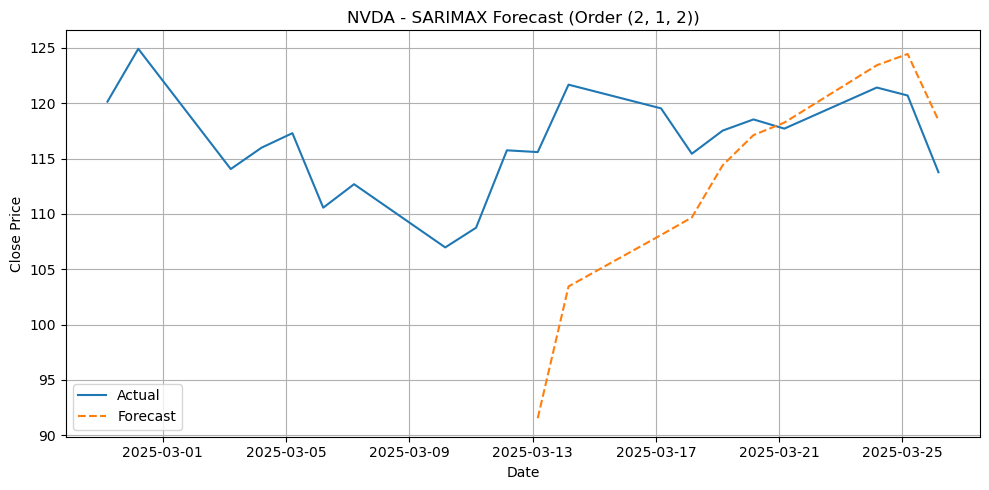


===== Processing TSLA =====
Auto-ARIMA Suggested Order: (0, 1, 0)
Order (0, 1, 0) - RMSE: 4.2915, AIC: 4374.51, BIC: 4436.22
Order (2, 1, 2) - RMSE: 5.0215, AIC: 4355.38, BIC: 4436.03
Order (3, 1, 3) - RMSE: 4.3437, AIC: 4358.01, BIC: 4448.13
Forecast Accuracy: 98.62%
Best Model for TSLA — Order: (0, 1, 0), RMSE: 4.2915, AIC: 4374.51, BIC: 4436.22


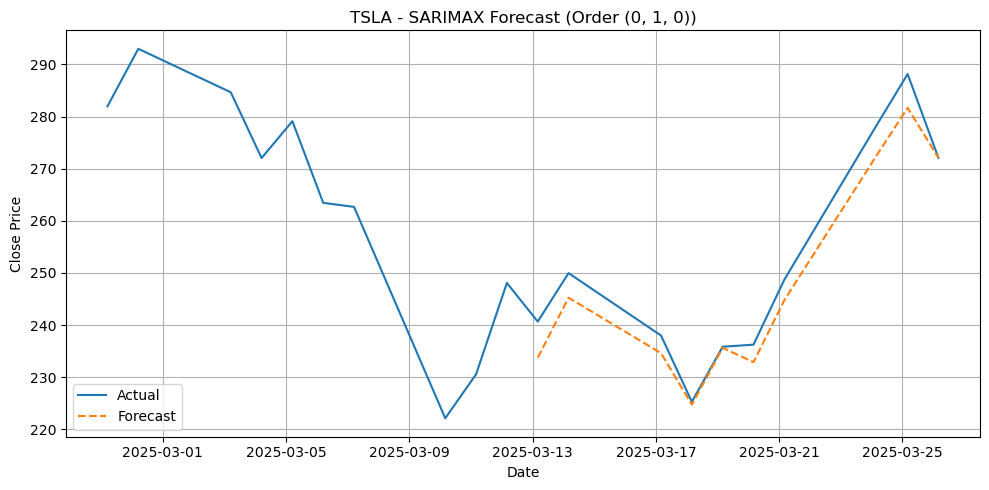

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")


#df = pd.read_csv("Merged_data_final.csv")
#df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
#df.dropna(subset=['Date'], inplace=True)
#df.sort_values('Date', inplace=True)

def add_engineered_features(stock_df):
    stock_df = stock_df.copy()
    stock_df['EMA_12'] = stock_df['Close'].ewm(span=12, adjust=False).mean()
    stock_df['EMA_26'] = stock_df['Close'].ewm(span=26, adjust=False).mean()
    stock_df['MACD'] = stock_df['EMA_12'] - stock_df['EMA_26']
    stock_df['MACD_Signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()
    delta = stock_df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    stock_df['RSI_14'] = 100 - (100 / (1 + rs))
    stock_df['Lag_Close'] = stock_df['Close'].shift(1)
    stock_df['Price_Change_Pct'] = stock_df['Close'].pct_change()
    stock_df['Volatility_7d'] = stock_df['Close'].rolling(window=7).std()
    stock_df['Weekday'] = stock_df['Date'].dt.weekday
    return stock_df

def suggest_sarimax_order(endog, exog):
    try:
        model = auto_arima(endog, exogenous=exog, seasonal=False, stepwise=True,
                           suppress_warnings=True, max_order=6, maxiter=30)
        return model.order
    except Exception as e:
        print(f"[Auto-ARIMA Error] {e}")
        return None

stocks = df['Stock'].unique()

for stock in stocks:
    print(f"\n===== Processing {stock} =====")
    stock_df = df[df['Stock'] == stock].copy()
    stock_df = add_engineered_features(stock_df)
    stock_df.set_index('Date', inplace=True)
    stock_df.sort_index(inplace=True)

    feature_cols = ['sentiment_mean', 'Volume', 'sentiment_count',
                    'Price_Change_Pct', 'Lag_Close', 'Volatility_7d', 'Weekday',
                    'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI_14']

    ts_df = stock_df[['Close'] + feature_cols].dropna()
    if len(ts_df) < 50:
        print(f"Not enough data for {stock}. Skipping.")
        continue

    endog = ts_df['Close']
    exog = ts_df[feature_cols]
    exog_scaled = pd.DataFrame(StandardScaler().fit_transform(exog),
                               index=exog.index, columns=exog.columns)

    order_grid = [(2, 1, 2), (3, 1, 3)]
    suggested_order = suggest_sarimax_order(endog, exog_scaled)
    if suggested_order and suggested_order not in order_grid:
        print(f"Auto-ARIMA Suggested Order: {suggested_order}")
        order_grid = [suggested_order] + order_grid

    best_rmse = float('inf')
    best_forecast = None
    best_order = None
    best_aic = None
    best_bic = None

    for order in order_grid:
        try:
            model = SARIMAX(endog, exog=exog_scaled, order=order, enforce_stationarity=False)
            result = model.fit(disp=False, maxiter=50)
            forecast = result.forecast(steps=10, exog=exog_scaled.iloc[-10:])
            true_values = endog[-10:]
            rmse = np.sqrt(mean_squared_error(true_values, forecast))

            aic = result.aic
            bic = result.bic

            print(f"Order {order} - RMSE: {rmse:.4f}, AIC: {aic:.2f}, BIC: {bic:.2f}")

            if rmse < best_rmse:
                best_rmse = rmse
                best_forecast = forecast
                best_order = order
                best_aic = aic
                best_bic = bic
        except Exception as e:
            print(f"Error with order {order}: {e}")
            continue

    if best_forecast is not None:
        valid_idx = true_values != 0
        if valid_idx.sum() > 0:
            true_vals = true_values[valid_idx].to_numpy()
            forecast_vals = best_forecast[-len(true_vals):].to_numpy()
            mape = np.mean(np.abs((true_vals - forecast_vals) / true_vals)) * 100
            accuracy = 100 - mape
            print(f"Forecast Accuracy: {accuracy:.2f}%")

        print(f"Best Model for {stock} — Order: {best_order}, RMSE: {best_rmse:.4f}, AIC: {best_aic:.2f}, BIC: {best_bic:.2f}")

        plt.figure(figsize=(10, 5))
        plt.plot(endog[-20:], label='Actual')
        plt.plot(endog.index[-10:], best_forecast, label='Forecast', linestyle='--')
        plt.title(f'{stock} - SARIMAX Forecast (Order {best_order})')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid forecast for this stock.")


#### **Results Summary**
| Stock | Best Order | RMSE | AIC | BIC | Forecast Accuracy (%) |
|-------|------------|------|-----|-----|------------------------|
| AAPL  | (2,1,2)    | 0.78 |1461.80|1542.43| 99.70 |
| AMZN  | (3,1,3)    | 1.83 |2200.99|2291.11| 99.19 |
| GOOGL | (0,1,0)    | 0.83 |1830.54|1892.23| 99.62 |
| META  | (3,1,3)    | 30.34|4398.65|4488.74| 95.38 |
| MSFT  | (2,1,2)    | 1.00 |2860.46|2941.05| 99.80 |
| NVDA  | (2,1,2)    |10.61 |1543.56|1624.15| 93.65 |
| TSLA  | (0,1,0)    | 4.29 |4374.51|4436.22| 98.62 |

#### **Model Insights**
- SARIMAX consistently outperformed LSTM in RMSE and accuracy across most stocks.
- The inclusion of exogenous variables (sentiment & technical indicators) improved forecast reliability.
- The model was prone to overfitting in some cases, evidenced by high RMSE gaps between training and forecast—flagged in real-time during model execution.


## Conclusion

In this project, we developed a comprehensive pipeline to forecast the next day’s closing price movement for seven leading technology stocks by integrating both historical market data and financial news sentiment. The primary objective was to evaluate the predictive power of different modeling strategies, specifically **Long Short-Term Memory (LSTM)** neural networks and **Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX)** models.

We initiated the workflow with rigorous **data collection** from Yahoo Finance and Financial Modeling Prep API, followed by **sentiment analysis** using FinBERT—an NLP model fine-tuned for financial language. This allowed us to quantify market sentiment and engineer additional features such as technical indicators (e.g., MACD, RSI, Volatility) and sentiment metrics (e.g., sentiment_mean, sentiment_count).

Our **Exploratory Data Analysis (EDA)** revealed several insightful patterns, including:
- Consistent upward trends for some stocks (e.g., AAPL, MSFT)
- Positive correlation between high sentiment and next-day returns
- Strong volatility in stocks like TSLA and NVDA

### Modeling Summary

- **Model 1: LSTM**  
  LSTM models were trained to classify the direction (UP/DOWN) of the next day’s stock movement using a sequence of engineered features. While LSTM showed modest accuracy for some stocks, it generally suffered from class imbalance and limited sequence depth, leading to inconsistent results.

- **Model 2: SARIMAX**  
  SARIMAX models incorporated both time series structure and exogenous variables (sentiment and technical indicators). Through manual and auto-order tuning ((p,d,q)), SARIMAX consistently outperformed LSTM in terms of **RMSE**, **AIC/BIC**, and **forecast accuracy**.

## Final Takeaway

The SARIMAX model demonstrated **superior reliability and interpretability**, making it more suitable for short-term forecasting tasks in this context. However, LSTM’s capacity for capturing long-term dependencies suggests that it could be beneficial with larger datasets or real-time streaming inputs. Future extensions may involve:
- Hybrid SARIMAX-LSTM architectures
- Attention-based neural networks
- Real-time inference systems on cloud platforms



## Future Work

While the current study effectively combines financial sentiment and time-series modeling to forecast stock price direction, there remains substantial scope for improvement and extension. Future work could focus on the following areas:

1. **Advanced Deep Learning Architectures**  
   Explore more sophisticated models such as Transformers, Attention-based LSTMs, or Temporal Convolutional Networks (TCNs) to better capture long-term dependencies and temporal dynamics in financial data.

2. **Real-Time Prediction Pipeline**  
   Deploy the pipeline on a cloud-based infrastructure (e.g., AWS, GCP) to support real-time stock prediction using streaming financial news and market data.

3. **Hybrid Modeling Approaches**  
   Combine the strengths of statistical models like SARIMAX with LSTM-based models to build hybrid ensembles that balance interpretability with predictive power.

4. **Feature Expansion and Selection**  
   Integrate macroeconomic indicators (e.g., interest rates, inflation), technical chart patterns, or alternative data sources (e.g., Reddit, Twitter sentiment) to further enrich the feature set.

5. **Explainability and Interpretability**  
   Utilize SHAP or LIME for model explainability to understand feature contributions, especially for complex deep learning models.

6. **Robust Evaluation Metrics**  
   Incorporate additional evaluation methods such as Profitability Simulations, Sharpe Ratio, and Backtesting with transaction costs to assess real-world applicability.

7. **Cross-Market and Cross-Sector Generalization**  
   Extend the analysis to other market sectors beyond technology (e.g., energy, healthcare) or to global indices to assess generalizability of the modeling framework.

By addressing these areas, future research can aim to build more robust, scalable, and interpretable models for high-stakes financial forecasting applications.
